## Data Cleaning

In [118]:
import pandas as pd
import numpy as np
import warnings
import scorecardpy as sc
from string import ascii_letters

import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
import utils


application = pd.read_csv('/Users/will/Documents/GitHub/consumer-credit-risk/coursework2_application_sampled.csv')
performance = pd.read_csv('/Users/will/Documents/GitHub/consumer-credit-risk/coursework2_performance_data_sampled.csv')

# merge the data from the two csvs
data_full = performance.merge(application, on='LOAN SEQUENCE NUMBER', how='left')

# change monthly reoprting period to datetime
data_full['MONTHLY REPORTING PERIOD'] = pd.to_datetime(data_full['MONTHLY REPORTING PERIOD'], format='%Y%m')

# if column value is RA then it is 3
data_full['CURRENT LOAN DELINQUENCY STATUS'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x: 3 if x == 'RA' else x)

# change to int
data_full['CURRENT LOAN DELINQUENCY STATUS'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].astype(int)
# change the column CURRENT LOAN DELINQUENCY STATUS
# slide 13 4 intro to analytics
# if value is less then 3 then it is 0 # else it is 1 # zero represents no default # one represents default
data_full['DEFAULT'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x: 0 if x < 3 else 1)

# select only the rows where ZERO BALANCE REMOVAL UPB is not null
data_full = data_full[data_full['ZERO BALANCE REMOVAL UPB'].notnull()]

data_full['LGD'] = data_full['ACTUAL LOSS CALCULATION']/data_full['ZERO BALANCE REMOVAL UPB'] 

########### data cleaning ###########
data_full['CUMULATIVE MODIFICATION COST'].fillna(0, inplace=True)
data_full['STEP MODIFICATION FLAG'].fillna('Not modified', inplace=True)
data_full['PAYMENT DEFERRAL'].fillna('Not payment deferral', inplace=True)
data_full['DELINQUENT ACCRUED INTEREST'].fillna(0, inplace=True)
data_full['DELINQUENCY DUE TO DISASTER'].fillna('N', inplace=True)
data_full['BORROWER ASSISTANCE STATUS CODE'].fillna('N', inplace=True)
data_full['CURRENT MONTH MODIFICATION COST'].fillna(0, inplace=True)
data_full['RELIEF REFINANCE INDICATOR'].fillna('N', inplace=True)
data_full['SUPER CONFORMING FLAG'].fillna('N', inplace=True)
data_full['METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION'].fillna('unknown', inplace=True)

# Replace specific missing values with 'np.nan'
missing_value_map = {
    'CREDIT SCORE': [9999],
    'FIRST TIME HOMEBUYER FLAG': [9],
    'MI PERCENT': [999],
    'NUMBER OF UNITS': [99],
    'OCCUPANCY STATUS': [9],
    'ORIGINAL CLTV': [999],
    'ORIGINAL DTI RATIO': [999],
    'ORIGINAL LTV': [999],
    'CHANNEL': [9],
    'PROPERTY TYPE': [99],
    'LOAN PURPOSE': [9],
    'NUMBER OF BORROWERS': [99],
    'PROGRAM INDICATOR': [9],
    'PROPERTY VALUATION METHOD': [9],
    'MI CANCELLATION INDICATOR': [9, 7]
}

for column, values in missing_value_map.items():
    if column in data_full.columns:
        data_full[column] = data_full[column].replace(values, np.nan)


# List of columns to convert to datetime
date_columns = [
    'MONTHLY REPORTING PERIOD', 
    'FIRST PAYMENT DATE', 
    'MATURITY DATE'
]

# Convert the specified columns to datetime
for column in date_columns:
    if column in data_full.columns:
        data_full[column] = pd.to_datetime(data_full[column], errors='coerce')

# drop the rows where the ACTUAL LOSS CALCULATION is null
data_full = data_full[data_full['ACTUAL LOSS CALCULATION'].notnull()]

# handle null values
data_full['DEFECT SETTLEMENT DATE'].fillna('unknown', inplace=True)  # Replace with 'unknown' or an appropriate value
data_full['MODIFICATION FLAG'].fillna('N', inplace=True)  # Replace with 'N' (assuming 'N' means no modification)
data_full['PRE-RELIEF REFINANCE LOAN SEQUENCE NUMBER'].fillna('N', inplace=True)  # Replace with 0 or another default value
data_full['PROPERTY VALUATION METHOD'].fillna('unknown', inplace=True)  # Replace with 'unknown' or an appropriate value

# change the object type columns to category
cat_columns = data_full.select_dtypes(include=['object']).columns
for column in cat_columns:
    data_full[column] = data_full[column].astype('category')
    data_full[column] = data_full[column].astype('category')


# make training data
data_full_in_time = data_full[data_full['MONTHLY REPORTING PERIOD'] < '2022-06-01']

# make out of time data
data_full_oot = data_full[data_full['MONTHLY REPORTING PERIOD'] == '2023-06-01']

# remove columns that arent needed
data_full_in_time.drop(columns=['MONTHLY REPORTING PERIOD', 'MATURITY DATE', 'SELLER NAME', 'FIRST PAYMENT DATE', 'SERVICER NAME',
                        'DUE DATE OF LAST PAID INSTALLMENT (DDLPI)', 'MI RECOVERIES',
                        'NET SALE PROCEEDS', 'NON MI RECOVERIES', 'TOTAL EXPENSES',
                        'LEGAL COSTS', 'MAINTENANCE AND PRESERVATION COSTS',
                        'TAXES AND INSURANCE', 'MISCELLANEOUS EXPENSES','ACTUAL LOSS CALCULATION'], inplace=True)

# remove columns that arent needed
data_full_oot.drop(columns=['MONTHLY REPORTING PERIOD', 'MATURITY DATE', 'SELLER NAME', 'FIRST PAYMENT DATE', 'SERVICER NAME',
                        'DUE DATE OF LAST PAID INSTALLMENT (DDLPI)', 'MI RECOVERIES',
                        'NET SALE PROCEEDS', 'NON MI RECOVERIES', 'TOTAL EXPENSES',
                        'LEGAL COSTS', 'MAINTENANCE AND PRESERVATION COSTS',
                        'TAXES AND INSURANCE', 'MISCELLANEOUS EXPENSES','ACTUAL LOSS CALCULATION'], inplace=True)

# Split the data into features and target
X = data_full_in_time.drop(columns=['LGD'])
y = data_full_in_time['LGD']

# split the data into features and target for oot
X_oot = data_full_oot.drop(columns=['LGD'])
y_oot = data_full_oot['LGD']

# do split test train but do it by the LOAN SEQUENCE NUMBER
X_train, X_test, y_train, y_test = utils.train_test_split_by_group(X, y, 'LOAN SEQUENCE NUMBER', test_size=0.2,  random_state=42)

# remove the LOAN SEQUENCE NUMBER from the train and test data
X_train.drop(columns=['LOAN SEQUENCE NUMBER'], inplace=True)
X_test.drop(columns=['LOAN SEQUENCE NUMBER'], inplace=True)

#X_train = pd.get_dummies(X_train, drop_first=True)
#X_test = pd.get_dummies(X_test, drop_first=True)

In [119]:
from sklearn.preprocessing import StandardScaler

# Select only numeric columns
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

# Scale numeric columns only
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

X_test_scaled = X_test.copy()
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [111]:
# get the top correlations with the target
correlations = data_full_in_time.corr()['LGD'].sort_values(ascending=False)

#correlations

## XGBoosting

In [120]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

#xgb = XGBRegressor(objective='reg:squarederror', random_state=42, enable_categorical=True)

xgb = XGBRegressor(max_depth=2,                 # Depth of each tree
                      learning_rate=0.1,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                      n_estimators=150,             # How many trees to use, the more the better, but decrease learning rate if many used.
                      verbosity=1,                  # If to show more errors or not.
                      objective='reg:squarederror',  # Type of target variable.
                      booster='gbtree',             # What to boost. Trees in this case.
                      n_jobs=2,                    # Parallel jobs to run. Set your processor number.
                      gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                      subsample=0.632,              # Subsample ratio. Can set lower
                      colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                      colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                      colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                      reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                      reg_lambda=0,                 # Regularizer for first fit.
                      random_state=20230331,        # Seed
                      tree_method='hist',           # How to train the trees?
                      #gpu_id=0                     # With which GPU?
                      eval_metric=mean_squared_error, # Metric used for monitoring the training result and early stopping.
                      enable_categorical=True
                      #early_stopping_rounds=5 #  Validation metric needs to improve at least once in every early_stopping_rounds round(s) to continue training.
                      )

param_grid = {      
    'max_depth': [1,2,3],               
    'learning_rate': [0.25, 0.3, 0.35, 0.4]       
}

grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=0
)

grid_search_xgb.fit(X_train_scaled, y_train)

best_xgb = grid_search_xgb.best_estimator_
print("Best XGBoost parameters:", grid_search_xgb.best_params_)

y_pred_xgb_train = best_xgb.predict(X_train_scaled)
y_pred_xgb_test = best_xgb.predict(X_test_scaled)

print("\n XGB Train Performance:")
print(f"MSE: {mean_squared_error(y_train, y_pred_xgb_train):}")

print("\n XGB Test Performance:")
print(f"MSE: {mean_squared_error(y_test, y_pred_xgb_test):}")




Best XGBoost parameters: {'learning_rate': 0.25, 'max_depth': 3}

 XGB Train Performance:
MSE: 0.007229937629838465

 XGB Test Performance:
MSE: 0.04216860670259166


<Figure size 720x576 with 0 Axes>

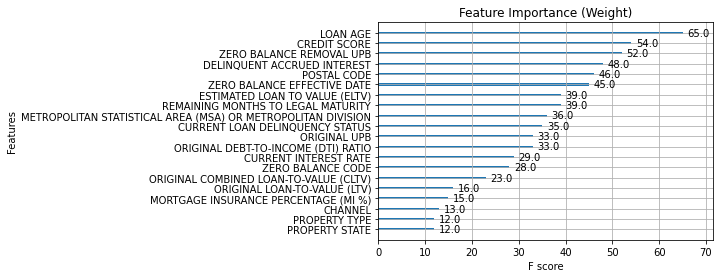

In [122]:
# get the xgboost feature importance
import matplotlib.pyplot as plt
from xgboost import plot_importance
plt.figure(figsize=(10, 8))
plot_importance(best_xgb, max_num_features=20, importance_type='weight', title='Feature Importance (Weight)', xlabel='F score')
plt.show()


In [123]:
import shap

# Create SHAP explainer from fitted model
explainer = shap.Explainer(best_xgb, X_test_scaled)

# Compute SHAP values
shap_values = explainer(X_test)

# Summary plot (variable importance overall)
shap.summary_plot(shap_values, X_test)

# Automatically get top 5 important variables
top5_features = shap_values.abs.mean(0).values.argsort()[-5:][::-1]
top5_names = X_test.columns[top5_features]

# Draw SHAP dependence plots
for feature in top5_names:
    shap.dependence_plot(feature, shap_values.values, X_test, show=True)

Found a NULL input array in _cext_dense_tree_update_weights!


TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

In [124]:
X_test_scaled.dtypes

CURRENT ACTUAL UPB                                               float64
CURRENT LOAN DELINQUENCY STATUS                                  float64
LOAN AGE                                                         float64
REMAINING MONTHS TO LEGAL MATURITY                               float64
DEFECT SETTLEMENT DATE                                          category
MODIFICATION FLAG                                               category
ZERO BALANCE CODE                                                float64
ZERO BALANCE EFFECTIVE DATE                                      float64
CURRENT INTEREST RATE                                            float64
CURRENT NON-INTEREST BEARING UPB                                 float64
CUMULATIVE MODIFICATION COST                                     float64
STEP MODIFICATION FLAG                                          category
PAYMENT DEFERRAL                                                category
ESTIMATED LOAN TO VALUE (ELTV)                     

In [ ]:
X_test

In [108]:
X_test_scaled.isna().sum().sort_values(ascending=False)

DEFECT SETTLEMENT DATE                                          87
MODIFICATION FLAG                                               80
PRE-RELIEF REFINANCE LOAN SEQUENCE NUMBER                       74
PROPERTY VALUATION METHOD                                       47
CURRENT ACTUAL UPB                                               0
PROPERTY TYPE                                                    0
ORIGINAL DEBT-TO-INCOME (DTI) RATIO                              0
ORIGINAL UPB                                                     0
ORIGINAL LOAN-TO-VALUE (LTV)                                     0
ORIGINAL INTEREST RATE                                           0
CHANNEL                                                          0
PREPAYMENT PENALTY MORTGAGE (PPM) FLAG                           0
AMORTIZATION TYPE                                                0
PROPERTY STATE                                                   0
ORIGINAL LOAN TERM                                            